In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Импорт данных

In [3]:
import os

root_dir = "data"
dataframes = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.split('.')[-1] != 'csv':
            continue

        file_path = os.path.join(dirpath, filename)
        df = pd.read_csv(file_path)

        df['file_path'] = file_path
        df['measure_type'] = dirpath.split('\\')[-1]
        df['id'] = dirpath.split('\\')[-2]
        df['session_name'] = filename.split('-')[1].split('.')[0].split('_')[0]
        df['session_id'] = filename.split('-')[1].split('.')[0].split('_')[1]
        df['date'] = filename.split('-')[0]
        df['target'] = dirpath.split('\\')[-3]

        dataframes.append(df)

# Объединяем все датафреймы
combined_df = pd.concat(dataframes, ignore_index=True)

print(f"Объединено {len(dataframes)} файлов, всего строк: {len(combined_df)}")

Объединено 2929 файлов, всего строк: 11029896


In [4]:
combined_df

,time_sec,value,file_path,measure_type,id,session_name,session_id,date,target
0,0.000000,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
1,0.127029,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
2,0.254058,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
3,0.381087,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
4,0.508116,208.246927,data\hypoxia\1\bpm\20250908-07500001_1.csv,bpm,1,07500001,1,20250908,hypoxia
...,...,...,...,...,...,...,...,...,...
11029891,33.408610,12.215724,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular
11029892,33.535639,12.215724,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular
11029893,33.662668,12.215724,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular
11029894,33.789697,12.150747,data\regular\9\uterus\20250908-04800007_2.csv,uterus,9,04800007,2,20250908,regular


### Анализ данных

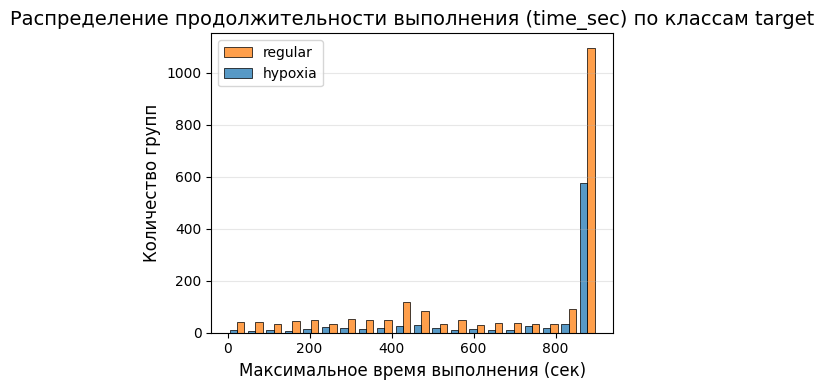

In [9]:
# Преобразуем результат группировки в плоский DataFrame
grouped_df = combined_df.groupby(['file_path','target']).agg({'time_sec':lambda x:(x.max()-x.min())}).reset_index()

# Строим гистограмму с разделением по target
plt.figure(figsize=(5, 4))
sns.histplot(
    data=grouped_df,
    x='time_sec',
    hue='target',
    multiple='dodge',  # Располагаем столбцы рядом
    bins=20,
    shrink=0.8,        # Уменьшаем ширину столбцов для лучшего разделения
    kde=False
)
# Оформление графика
plt.title('Распределение продолжительности выполнения (time_sec) по классам target', fontsize=14)
plt.xlabel('Максимальное время выполнения (сек)', fontsize=12)
plt.ylabel('Количество групп', fontsize=12)
plt.legend(['regular','hypoxia'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Подготовка данных

In [ ]:
import numpy as np
from scipy.signal import butter, sosfiltfilt
import pandas as pd
from scipy.interpolate import interp1d

def preprocess_fetal_signals(bpm_data, uterus_data, fs_target=4.0):
    """
    Оптимальная обработка сигналов фетального монитора с учетом особенностей обоих сигналов.
    
    Параметры:
    bpm_data -- DataFrame с колонками ['time_sec', 'value'] для ЧСС
    uterus_data -- DataFrame с колонками ['time_sec', 'value'] для маточных сокращений
    fs_target -- целевая частота дискретизации (4 Гц - оптимально для edge-устройств)
    
    Возвращает:
    filtered_bpm -- отфильтрованный сигнал ЧСС с оригинальными временными метками
    filtered_uterus -- отфильтрованный сигнал маточных сокращений с оригинальными временными метками
    """
    # 1. Подготовка данных: интерполяция на общую равномерную временную шкалу
    start_time = max(bpm_data['time_sec'].min(), uterus_data['time_sec'].min())
    end_time = min(bpm_data['time_sec'].max(), uterus_data['time_sec'].max())
    
    # Создаем общую временную шкалу с целевой частотой
    total_samples = int((end_time - start_time) * fs_target) + 1
    common_time = np.linspace(start_time, end_time, total_samples)
    
    # Интерполируем оба сигнала на общую шкалу
    f_bpm = interp1d(bpm_data['time_sec'], bpm_data['value'], kind='linear', 
                    bounds_error=False, fill_value="extrapolate")
    f_uterus = interp1d(uterus_data['time_sec'], uterus_data['value'], kind='linear', 
                       bounds_error=False, fill_value="extrapolate")
    
    bpm_interp = f_bpm(common_time)
    uterus_interp = f_uterus(common_time)
    
    # 2. Удаление выбросов (движение матери/датчика)
    bpm_clean = _remove_outliers(bpm_interp, window_size=int(fs_target*10), 
                                std_threshold=3.0, fs=fs_target)
    uterus_clean = _remove_outliers(uterus_interp, window_size=int(fs_target*30), 
                                  std_threshold=2.5, fs=fs_target)
    
    # 3. Фильтрация с оптимальными параметрами для каждого сигнала
    filtered_bpm_interp = _filter_fhr(bpm_clean, fs=fs_target)
    filtered_uterus_interp = _filter_uterus(uterus_clean, fs=fs_target)
    
    # 4. Возвращаем сигналы к оригинальным временным меткам
    f_bpm_final = interp1d(common_time, filtered_bpm_interp, kind='linear', 
                         bounds_error=False, fill_value="extrapolate")
    f_uterus_final = interp1d(common_time, filtered_uterus_interp, kind='linear', 
                            bounds_error=False, fill_value="extrapolate")
    
    # Возвращаем только те временные точки, которые были в исходных данных
    filtered_bpm = pd.DataFrame({
        'time_sec': bpm_data['time_sec'],
        'value': f_bpm_final(bpm_data['time_sec'])
    })
    
    filtered_uterus = pd.DataFrame({
        'time_sec': uterus_data['time_sec'],
        'value': f_uterus_final(uterus_data['time_sec'])
    })
    
    return filtered_bpm, filtered_uterus

def _remove_outliers(signal, window_size, std_threshold, fs):
    """Удаление выбросов, вызванных движениями матери или датчика"""
    # Используем скользящее среднее для выявления аномалий
    half_window = window_size // 2
    cleaned = np.copy(signal)
    
    for i in range(half_window, len(signal) - half_window):
        window = signal[i-half_window:i+half_window]
        mean = np.mean(window)
        std = np.std(window)
        
        # Если значение отклоняется более чем на threshold * std, заменяем его
        if abs(signal[i] - mean) > std_threshold * std:
            # Заменяем на среднее значение окна
            cleaned[i] = mean
    
    return cleaned

def _filter_fhr(fhr_signal, fs=4.0):
    """Оптимизированная фильтрация ЧСС плода с акцентом на сохранение клинически значимых паттернов"""
    # Параметры для ЧСС: частота среза 0.08 Гц, порядок 3
    # Это удаляет высокочастотный шум (>0.1 Гц), но сохраняет ускорения и децелерации
    nyq = 0.5 * fs
    normal_cutoff = 0.08 / nyq
    sos = butter(3, normal_cutoff, btype='low', output='sos')
    return sosfiltfilt(sos, fhr_signal)

def _filter_uterus(uterus_signal, fs=4.0):
    """Оптимизированная фильтрация маточных сокращений"""
    # Параметры для маточных сокращений: частота среза 0.01 Гц, порядок 4
    nyq = 0.5 * fs
    normal_cutoff = 0.01 / nyq
    sos = butter(4, normal_cutoff, btype='low', output='sos')
    filtered = sosfiltfilt(sos, uterus_signal)
    
    # Нормализация амплитуды (критично для маточных сокращений)
    min_val = np.min(filtered)
    max_val = np.max(filtered)
    if max_val > min_val:
        normalized = (filtered - min_val) / (max_val - min_val + 1e-8)
    else:
        normalized = filtered
    
    # Пороговая фильтрация для выделения реальных сокращений
    threshold = 0.15 * np.max(normalized)  # 15% от максимальной амплитуды
    contractions = np.where(normalized > threshold, normalized, 0)
    
    return contractions

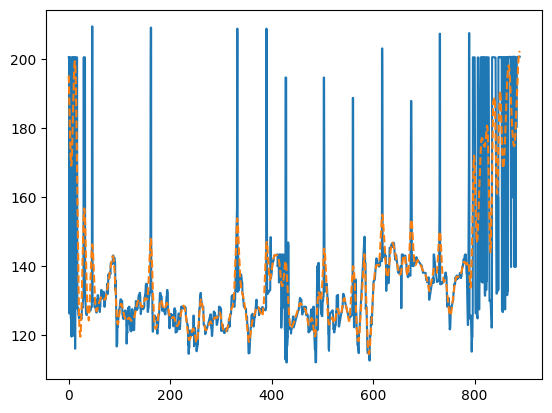

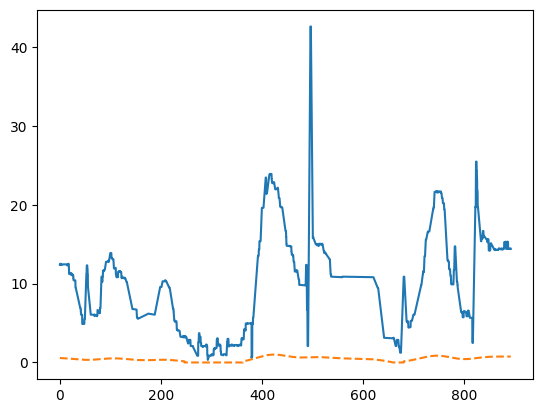

In [197]:
# Пример использования
import pandas as pd

# Загрузка данных (предполагается, что данные уже в формате DataFrame)
bpm_data = combined_df[combined_df['file_path'] == 'data\\hypoxia\\27\\bpm\\20250915-00200003_1.csv']
uc_data = combined_df[combined_df['file_path'] == 'data\\hypoxia\\27\\uterus\\20250915-00200003_2.csv']

# Фильтрация сигналов
filtered_bpm, filtered_uterus = preprocess_fetal_signals(bpm_data, uc_data)

plt.figure()
plt.plot(bpm_data['time_sec'], bpm_data['value'])
plt.plot(filtered_bpm['time_sec'], filtered_bpm['value'], '--')

plt.figure()
plt.plot(uc_data['time_sec'], uc_data['value'])
plt.plot(filtered_uterus['time_sec'], filtered_uterus['value'], '--')

In [171]:
from random import uniform

time_next = 0
time_end = min(bpm_data['time_sec'].max(), uc_data['time_sec'].max())

def has_more_data():
    return (bpm_data['time_sec'] > time_next).any() and (uc_data['time_sec'] > time_next).any()

def get_next_chunk():
    global time_next
    time_prev = time_next
    time_next += time_next+uniform(1,4)
    print(time_prev, time_next)
    return [bpm_data[(time_prev < bpm_data['time_sec']) & (bpm_data['time_sec']< time_next)],
            uc_data[(time_prev < uc_data['time_sec']) & (uc_data['time_sec'] < time_next)]]

In [174]:
# Инициализация процессора
processor = FetalSignalProcessor(fs=4.0)

# Создаем пустой DataFrame для результатов
df_filtered = pd.DataFrame(columns=['time', 'bpm_filtered', 'uc_filtered'])

# Первый фрагмент данных
[first_bpm, first_uc] = get_next_chunk()
result = processor.process_stream(first_bpm, first_uc, reset_state=True)

# Проверяем, есть ли данные для добавления
if len(result['time']) > 0:
    df_filtered = pd.DataFrame({
        'time': result['time'],
        'bpm_filtered': result['bpm_filtered'],
        'uc_filtered': result['uc_filtered']
    })

# Последующие фрагменты
chunk_count = 1
while has_more_data():
    [bpm_chunk, uc_chunk] = get_next_chunk()
    result = processor.process_stream(bpm_chunk, uc_chunk)
    
    # Проверяем, есть ли данные для добавления
    if len(result['time']) > 0:
        new_df = pd.DataFrame({
            'time': result['time'],
            'bpm_filtered': result['bpm_filtered'],
            'uc_filtered': result['uc_filtered']
        })
        df_filtered = pd.concat([df_filtered, new_df], ignore_index=True)
    
    chunk_count += 1
    print(f"Обработано чанков: {chunk_count}, Размер буфера: {len(processor.time_buffer)}")

# Если нет данных после обработки (буфер не заполнен)
if len(df_filtered) == 0:
    print("Недостаточно данных для обработки. Попробуйте увеличить количество чанков.")
else:
    # Собираем оригинальные данные для сравнения (предполагаем, что у нас есть полные данные)
    full_bpm = pd.DataFrame(columns=['time_sec', 'value'])
    full_uc = pd.DataFrame(columns=['time_sec', 'value'])
    
    # Перезапускаем генератор данных для сбора полных данных
    reset_data_generator()
    while has_more_data():
        [bpm_chunk, uc_chunk] = get_next_chunk()
        full_bpm = pd.concat([full_bpm, bpm_chunk], ignore_index=True)
        full_uc = pd.concat([full_uc, uc_chunk], ignore_index=True)
    
    # Строим графики
    plt.figure(figsize=(14, 10))
    
    # График ЧСС
    plt.subplot(2, 1, 1)
    plt.plot(full_bpm['time_sec'], full_bpm['value'], 'b-', alpha=0.6, label='Оригинальный ЧСС')
    plt.plot(df_filtered['time'], df_filtered['bpm_filtered'], 'r-', linewidth=2, label='Отфильтрованный ЧСС')
    plt.title('Сравнение оригинального и отфильтрованного ЧСС')
    plt.xlabel('Время (сек)')
    plt.ylabel('Удары в минуту')
    plt.legend()
    plt.grid(True)
    
    # График маточных сокращений
    plt.subplot(2, 1, 2)
    plt.plot(full_uc['time_sec'], full_uc['value'], 'b-', alpha=0.6, label='Оригинальные сокращения')
    plt.plot(df_filtered['time'], df_filtered['uc_filtered'], 'r-', linewidth=2, label='Отфильтрованные сокращения')
    plt.title('Сравнение оригинальных и отфильтрованных маточных сокращений')
    plt.xlabel('Время (сек)')
    plt.ylabel('Интенсивность')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('fetal_signal_comparison.png', dpi=150)
    plt.show()
    
    # Проверка согласованности обработки
    print(f"Обработано {len(df_filtered)} точек из {len(full_bpm)} оригинальных")

63.88780552923363 130.6451427430768


ValueError: All arrays must be of the same length

In [157]:
df_filtered

,time,bpm_filtered,uc_filtered
0,0.127029,90.0,1.0
1,0.377029,90.0,1.0
2,0.627029,90.0,1.0
3,0.877029,90.0,1.0
4,1.127029,90.0,1.0
5,1.377029,90.0,1.0
6,1.627029,90.0,1.0
7,1.877029,90.0,1.000006
8,2.127029,90.0,1.00001
9,2.377029,90.0,1.000015


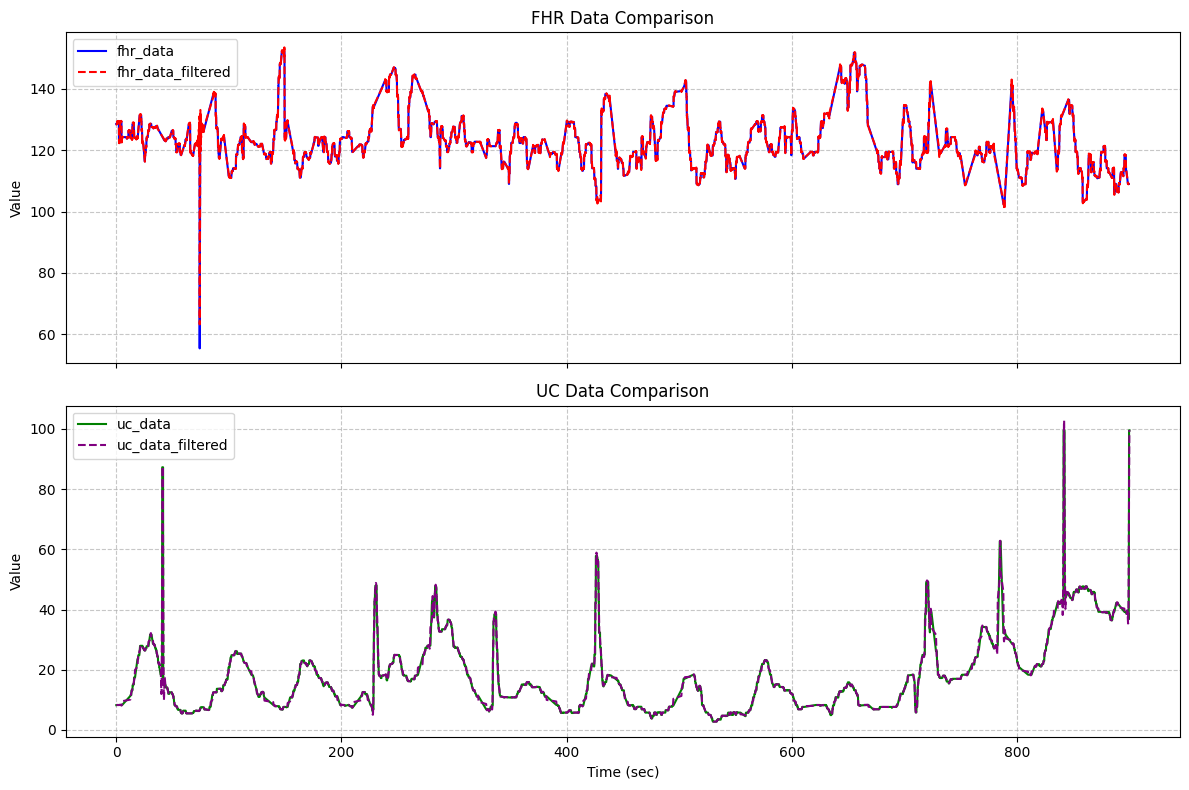

In [108]:
import matplotlib.pyplot as plt

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Первый график: FHR данные
axes[0].plot(fhr_data['time_sec'], fhr_data['value'], label='fhr_data', color='blue')
axes[0].plot(fhr_data['time_sec'], fhr_data_filtered, 
             linestyle='--', label='fhr_data_filtered', color='red')
axes[0].set_title('FHR Data Comparison')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# Второй график: UC данные
axes[1].plot(uc_data['time_sec'], uc_data['value'], label='uc_data', color='green')
axes[1].plot(uc_data['time_sec'], uc_data_filtered, 
             linestyle='--', label='uc_data_filtered', color='purple')
axes[1].set_title('UC Data Comparison')
axes[1].set_xlabel('Time (sec)')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

# Оптимизируем расположение
plt.tight_layout()
plt.show()